In [2]:
import numpy as np
import numpy as np
from itertools import permutations
import seaborn as sns
import random
import matplotlib.pyplot as plt


In [ ]:
#Ciao


# $\epsilon$-Greedy Algorithm | simoultaneous offers 

In [3]:
T = 100000
epsilon_0 = 0.01
eta = 0.05

## Agents' Initialization
## 5 agents in total, no sex distinction, true values 
N = 6     # Number of Agents 

epsilon_0 = 0.5  # initial probability of exploration
K = np.zeros(N)                                     

# Mean and std deviation of the noise signals (sampled form a std Normal )
noise_mean = 0 
noise_std = 0.5

In [4]:
## Initialization prior beliefs matrix 
## consistent with the priors of thompson sampling,
## we use identical initialization -- (no prior knowledge) and  0 values on the diagonal

np.random.seed(25)
Q = 0.5*np.ones((N, N))
np.fill_diagonal(Q, 0)  

In [5]:
## Initialization prior beliefs of being accepted probailities matrix
np.random.seed(25)
p = np.random.uniform(0, 1, size=(N, N))
np.fill_diagonal(p, 1)  

In [6]:
v = np.random.uniform(0, 0.99, (6,6))
N = 6       # Number of Agents 
np.fill_diagonal(v, 0)

v[0,1] = 1
v[1,0] = 1

v[2, 3] = 1
v[3,2] = 1

v[4,5] = 1
v[5,4] = 1


In [7]:
def greedy_proposal(i, Q , p ):
    '''This function returns the the index of agents to propose 
    under the greedy approach, for agent i '''
    q = np.array(Q[i])
    p_i = np.array(p[i])

    return np.argmax(p_i*q)

In [8]:
def invert_offers(offers):
    ' function to invert the offers being made '
    inverted_offers = {}
    for proposer, recipient in offers.items():
        inverted_offers.setdefault(recipient, []).append(proposer)
    return inverted_offers

In [9]:
def greedy_decision(i, offers, Q):
    'Function that decides wich to accept the offer to greedy decision'

    q = np.array(Q[i, offers])
    return offers[np.argmax(q)]

In [10]:
def initialize_value_matrix(N):
    # Create an NxN matrix with random values between 5 and 9
    matrix = np.random.uniform(0, 0.5, (N, N))
    matrix = (matrix + matrix.T) / 2
    
    # Fill the diagonal with 0
    np.fill_diagonal(matrix, 0)
    
    # Set specific symmetric pairs to 1
    for i in range(0, N, 2):
        if i+1 < N:
            matrix[i, i+1] = 1
            matrix[i+1, i] = 1
    
    return matrix

In [11]:
def initialize_prior_Q(N):
    'Initializes the prior values probabilities -- No information uniform initialization'

    Q = np.random.uniform(0, 1, size=(N, N))
    np.fill_diagonal(Q, 0) 

    return Q


In [12]:
def initialize_prior_p(N):
    'Initializes the prior probabilities p  of being accepted -- No information 0.5 initialization'

    p = np.random.uniform(0, 1, size=(N, N))
    np.fill_diagonal(p, 1)  
    return p

In [13]:
def observed_pairs(matrix):
    ' Given the binary allocation matrix returns the true observed pairings '
    n = len(matrix)
    result = []
    for i in range(n):
        for j in range(i+1, n):
            if matrix[i][j] == 1 and matrix[j][i] == 1:
                result.append((i, j))
    return result

In [35]:
def epsilon_greedy(T, N, e = 0.5, eta = 0.05):

    v = initialize_value_matrix(N)      # True values
    Q = initialize_prior_Q(N)           # prior of values
    p = initialize_prior_p(N)           # prior of probabilities 

    R = np.zeros((N, T))                # Initialize Regret Matrix 

    #print(v)
    #print(Q)
    #print(p)

    ## stable matchings set 
    stable_matching = set((x-1,x) for x in range(1, N, 2))
    n_stable_couples = []
    tau = []

    for t in range(T): 

        ## Proposal phase 
        offers = {}
        epsilon = e**((t+1)/1000)
        #print(epsilon)

        for i in range(N):
            if random.random() < epsilon:
                #print('I am exploriing')
            # Exploration: with probability epsilon
                offers[i] = random.choice(list(range(N)))
               # print(offers)
                
            else:
            # Greedy: with the remaining probability (1 - epsilon)
                #print(' I am NOT exploring ')
                offers[i] = greedy_proposal(i, Q, p)
               # print(offers)


        #print('offers \n')
        #print(offers)
            
        ## Acceptance phase
        offers_recievers = invert_offers(offers)
        m_matrix = np.zeros((N, N)) 

        for j in offers_recievers.keys():
            max_index = greedy_decision(j, offers_recievers[j], Q)
            m_matrix[j, max_index] = 1

        #print('proposed offers\n')
        #print(m_matrix)

        #print('observed_pairs\n')
        #print(observed_pairs(m_matrix))
        
        
        tau.append(1 if set(observed_pairs(m_matrix)) == stable_matching else 0 )

        ## Updates 
        for i in range(N):
            for j in range(N):
                if (m_matrix[i, j] == 1) and (m_matrix[j, i] ==1):
                    #print(f'updated match {i} and {j} \n')
                    ## Update the Q of the observed value - if matches take place
                    Q[i, j] =  Q[i, j]/2 +  (v[i, j])/2#(+ np.random.normal(noise_mean, noise_std, 1))/2 
                    ## update the probability of being accepted 
                    p[i, j] = (1-eta)*p[i, j] + eta 
                    #if tau[-1] ==1:
                        #print(Q[i, j])
                    R[i, t] = v[i, j] #- expectation of bernoulli distirbution
                    R[j, t] = v[i, j] #- expectation of bernoulli distribution

                elif (m_matrix[i, j] == 1) and (m_matrix[j, i] ==0) :
                    ## update the probability of not being accepted
                    p[i, j] = (1-eta)*p[i, j] 


        n_stable_couples.append(len( set(observed_pairs(m_matrix)) & stable_matching ))
        row = np.arange(1, T + 1)
        matrix = np.tile(row, (N, 1))
        R = matrix - np.cumsum(R, axis =1)
        a = N/2 - np.array(n_stable_couples)
        cum_market_unstability = np.cumsum(a)

    return observed_pairs(m_matrix), n_stable_couples, tau, Q, p, R, cum_market_unstability


In [15]:
z, n, t, Q, p= epsilon_greedy(30000, 6, e = 0.1) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


ValueError: too many values to unpack (expected 5)

In [18]:
def make_stability_plot_single(t, n_agents):
    plt.figure(figsize=(10, 2))
    plt.imshow([t], aspect='auto',cmap='RdYlGn', interpolation='nearest')
    plt.title(f'Stability Analysis - {n_agents} Agents')
    cbar = plt.colorbar()
    cbar.set_ticks([0, n_agents/2])
    cbar.set_ticklabels(['Unstable', 'Stable'])
    plt.show()

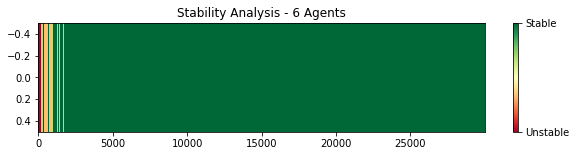

In [20]:
make_stability_plot_single(n, 6)

In [36]:
def make_stability_plot(t, agents, subplot_index, total_plots):
    plt.subplot(total_plots, 1, subplot_index)
    plt.imshow([t], aspect='auto', cmap='RdYlGn', interpolation='nearest')
    plt.title(f'Heatmap for - {agents} Agents')
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Unstable', 'Stable'])


def compare_heatmaps(trials, agent_values):
    total_plots = len(agent_values)
    plt.figure(figsize=(10, 2 * total_plots))
    
    for i, agents in enumerate(agent_values):
        _, n, _ , _, _= epsilon_greedy(trials, agents)
        make_stability_plot(n, agents, i + 1, total_plots)

    plt.tight_layout()
    plt.show()

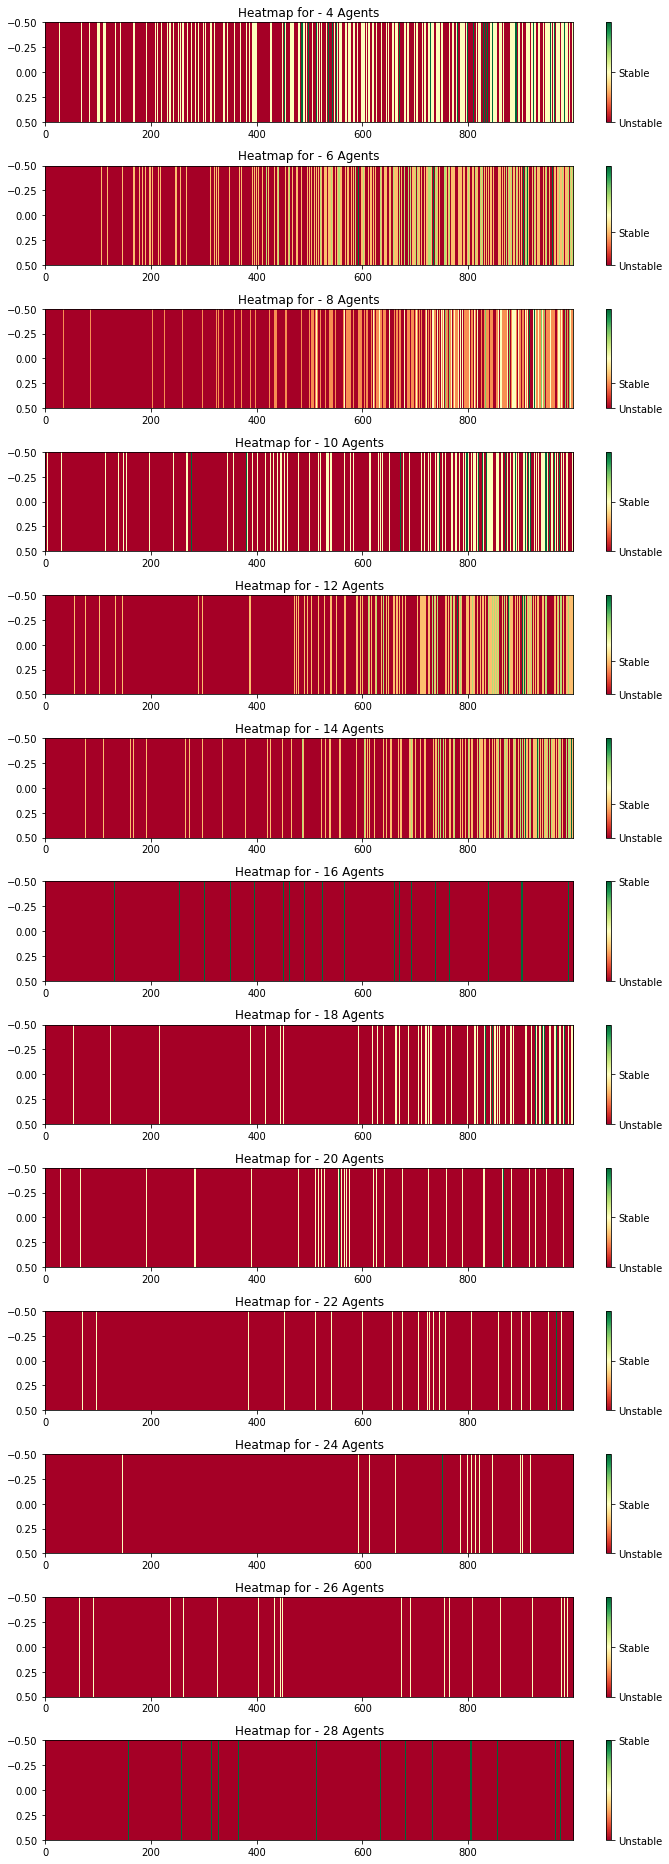

In [37]:
trials = 1000
agent_values = np.arange(4, 30, 2)  # Example values, adjust as needed

compare_heatmaps(trials, agent_values)

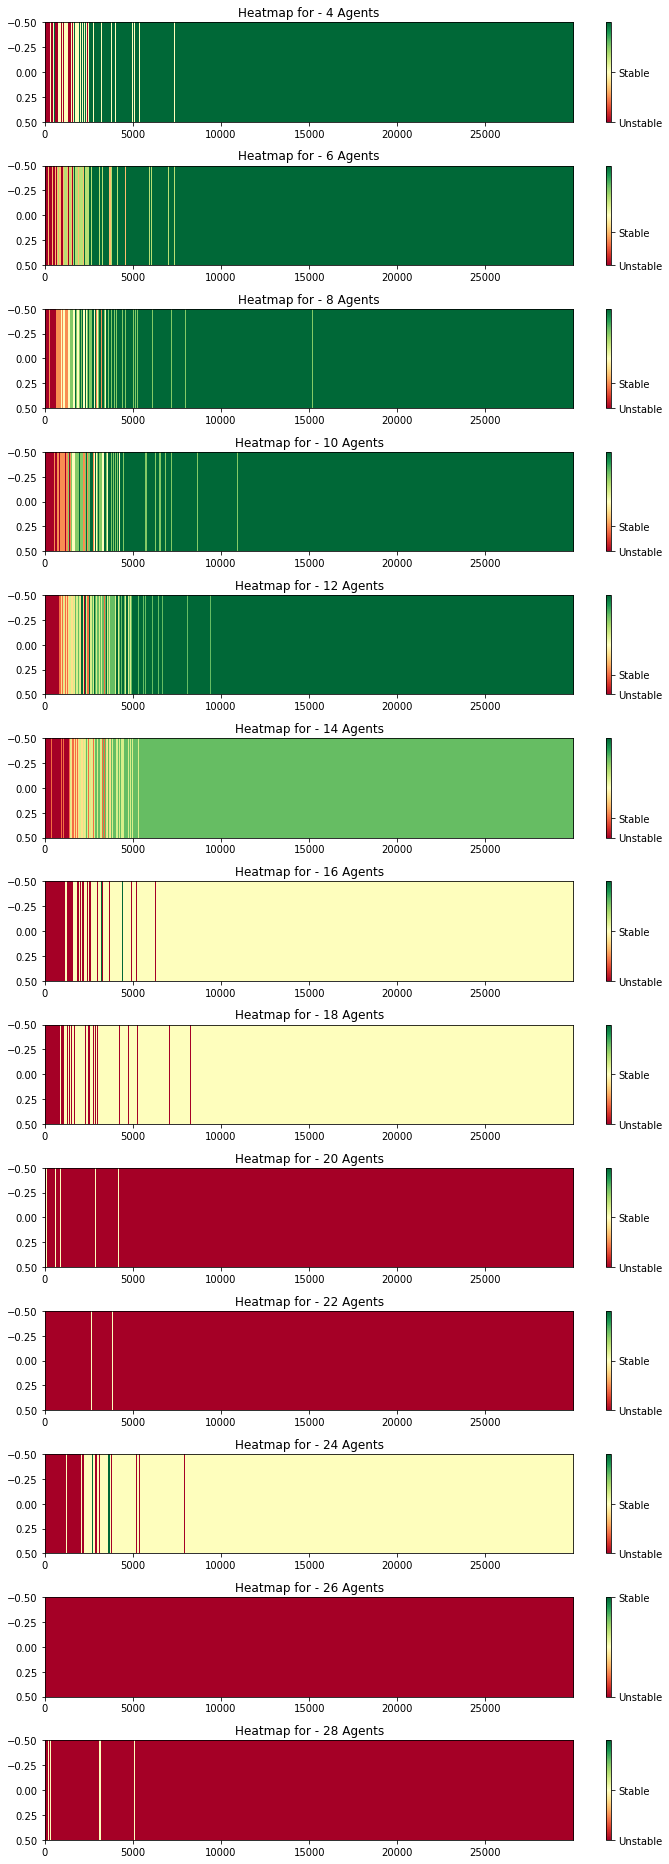

In [38]:
trials = 30000
agent_values = np.arange(4, 30, 2)  # Example values, adjust as needed

compare_heatmaps(trials, agent_values)

In [122]:
result_simulation = {key: 0 for key in N_agents}
T = 10000
for a in N_agents:
    for n in range(rounds): 

        #stable_matching = [(i, i+1) for i in range(0, a, 2)]
        matching, n, t  = epsilon_greedy(T, a)
    
        if  t[-1] == 1: 
            result_simulation[a] += 1 

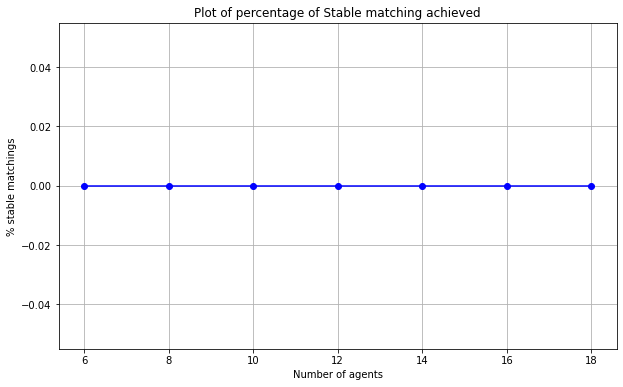

In [123]:
import matplotlib.pyplot as plt

# Provided dictionary

plt.figure(figsize=(10, 6))

plt.plot(result_simulation.keys(), result_simulation.values(), marker='o', linestyle='-', color='blue')
plt.xlabel('Number of agents')
plt.ylabel('% stable matchings')
plt.title('Plot of percentage of Stable matching achieved')
plt.grid(True)
plt.show()

## $\epsilon$- variants simulations -- Das Kamenica paper 

In [124]:
result_simulation_eps = {key: 0 for key in N_agents}
eps_values = np.linspace(0.1, 1, 10)
T = 10000

for e  in eps_values:
    for n in range(rounds): 

        matching, n, t  = epsilon_greedy(T, 8, e)
    
        if  t[-1] == 1: 
            result_simulation_eps[e] += 1 

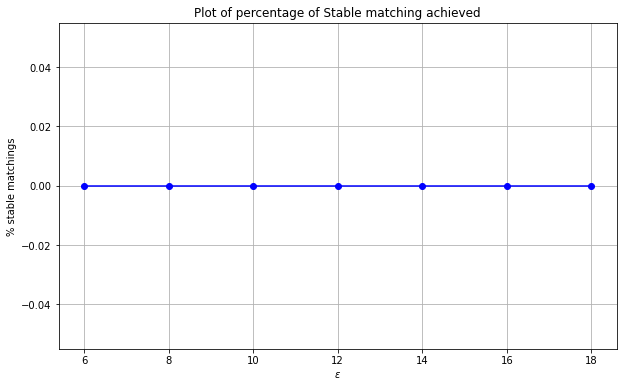

In [125]:
plt.figure(figsize=(10, 6))

plt.plot(result_simulation_eps.keys(), result_simulation_eps.values(), marker='o', linestyle='-', color='blue')
plt.xlabel('$\epsilon$')
plt.ylabel('% stable matchings')
plt.title('Plot of percentage of Stable matching achieved')
plt.grid(True)
plt.show()

## $\epsilon$-Greedy - Regret Anlaysis 

In [36]:
m, n, t, _, _, R, cum_market_unstability = epsilon_greedy(100000, 8)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


In [18]:
R.shape

(8, 100000)

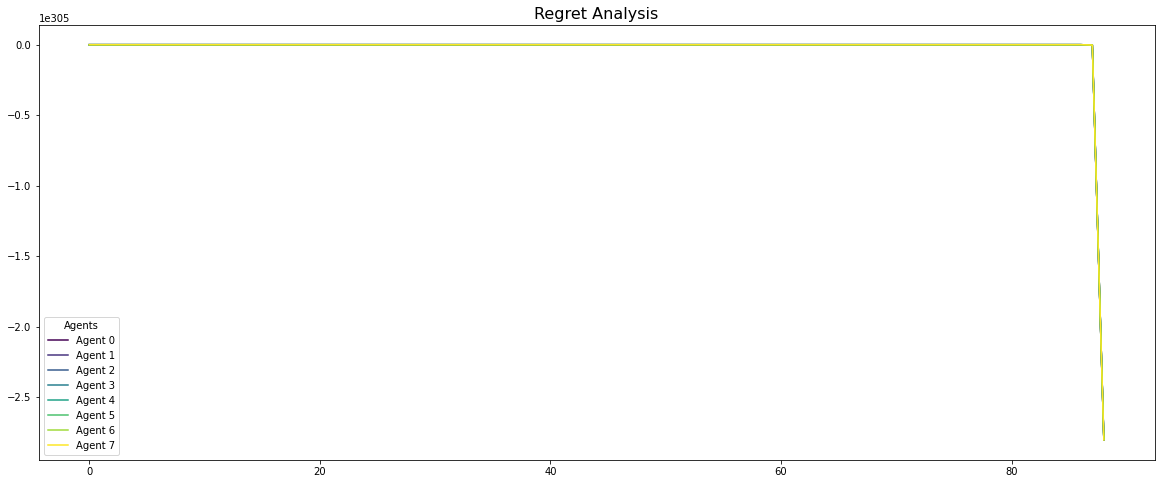

In [33]:
plt.figure(figsize=(20, 8))

# Define colors
colors = plt.cm.viridis(np.linspace(0, 1, 8))
# Plot data in a single plot with different colors

for i in range(8):
    plt.plot(R[i] , label=f'Agent {i}', color=colors[i])

# Add title and legend
plt.title('Regret Analysis', fontsize=16)
plt.legend(title='Agents')
# Show plot
plt.show()

In [34]:
R[6, 100]

-inf

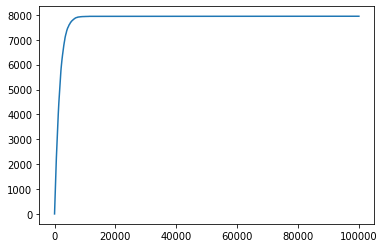

In [21]:
plt.plot(cum_market_unstability)

(0.0, 10000.0)

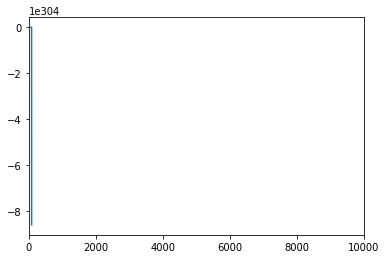

In [30]:
plt.plot(R[6])
plt.xlim(0, 10000)